# Setup


In [2]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
MyDrive


In [3]:
import os
import sys

BASE_PATH = '/gdrive/My Drive/colab_files/490_final/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision

sys.path.append(BASE_PATH)
import pt_util

In [ ]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.7"
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Defining Dataset and Dataloader

In [5]:
class PokemonDataset(Dataset):
  def __init__(self, csvfile, transform=None):
    self.annotations = pd.read_csv(csvfile)
    self.annotations['path'] = self.annotations['path'].str.replace('\\', '/')
    self.annotations = self.annotations[(self.annotations['path'].str.contains(".png")) | (self.annotations['path'].str.contains(".jpg"))]
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = self.annotations.iloc[index, 1]
    img = read_image(BASE_PATH + img_path, mode=torchvision.io.image.ImageReadMode.RGB)

    y_label = torch.tensor((self.annotations.iloc[index, 3]) - 1)

    if self.transform:
      img = self.transform(img)
    
    return img, y_label

In [ ]:
# edits = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((128, 128)),
#     transforms.ColorJitter(.1,.1,.1,.1),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     ])

edits = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

poke_data = PokemonDataset(BASE_PATH + 'data.csv', transform=edits)
split = [5404, 1352] # about 80-20
train_set, test_set = torch.utils.data.random_split(poke_data, split)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
print('size', images.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


size torch.Size([256, 3, 128, 128])


In [ ]:
print(labels[0]) # Bulby boy is pokemon #1

tensor(0)


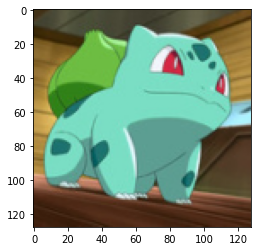

In [ ]:
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)));

# Baseline Model (Darknet Inspired)


In [6]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 2 * 2, 151)

        self.accuracy = None

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 64x64x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 32x32x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 16x16x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 8x8x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 4x4x256
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), kernel_size=2, stride=2) # 2x2x512

        x = torch.flatten(x, 1)                                                    # vector 2048
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [7]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy

# Baseline Model Train

Using device cpu
num cpus: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 5.0171, Accuracy: 7/1352 (1%)



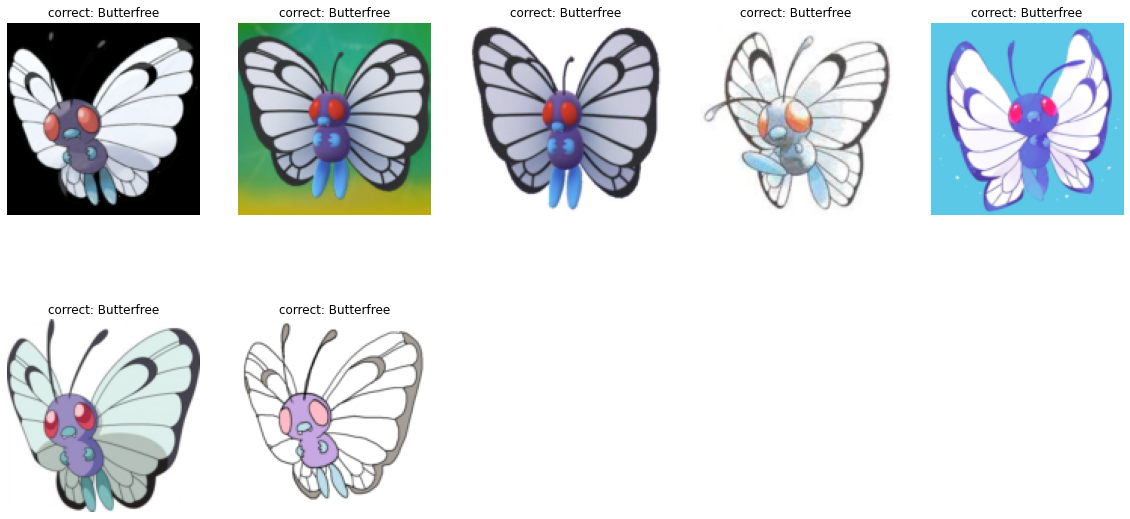

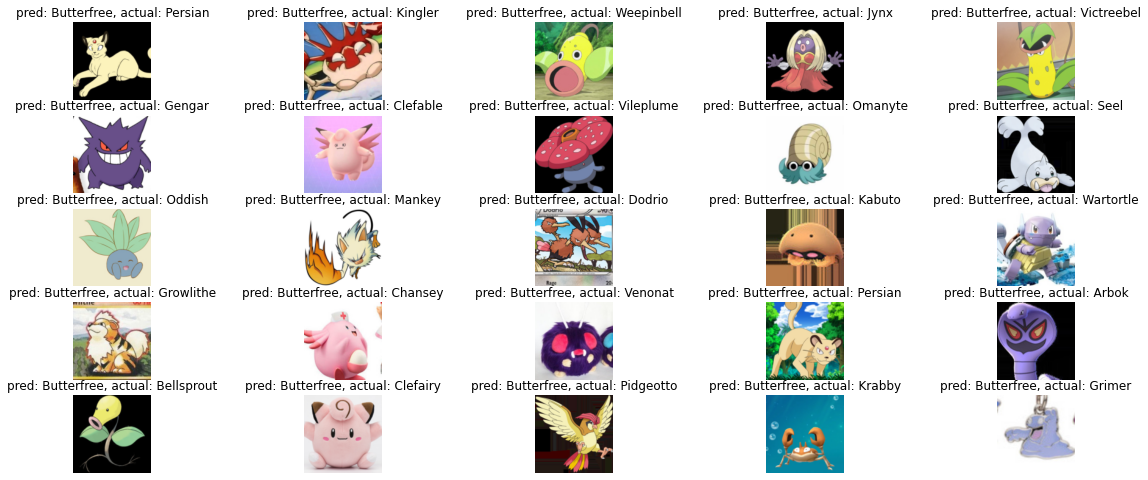

Tue Dec 14 01:53:07 2021 Train Epoch: 0 [0/5404 (0%)]	Loss: 5.221770

Test set: Average loss: 4.9030, Accuracy: 30/1352 (2%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.1/000.pt

Tue Dec 14 01:56:12 2021 Train Epoch: 1 [0/5404 (0%)]	Loss: 3.442202

Test set: Average loss: 3.3758, Accuracy: 254/1352 (19%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.1/001.pt

Tue Dec 14 01:59:03 2021 Train Epoch: 2 [0/5404 (0%)]	Loss: 2.344068

Test set: Average loss: 3.0522, Accuracy: 404/1352 (30%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.1/002.pt

Tue Dec 14 02:01:51 2021 Train Epoch: 3 [0/5404 (0%)]	Loss: 1.618319

Test set: Average loss: 2.0083, Accuracy: 642/1352 (47%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.1/003.pt

Tue Dec 14 02:04:36 2021 Train Epoch: 4 [0/5404 (0%)]	Loss: 1.003245

Test set: Average loss: 1.7292, Accuracy: 723/1352 (53%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.1/004.pt

Tue Dec 14 02:07:29 2021 Train Epoch: 5 [0/5404 (0%)

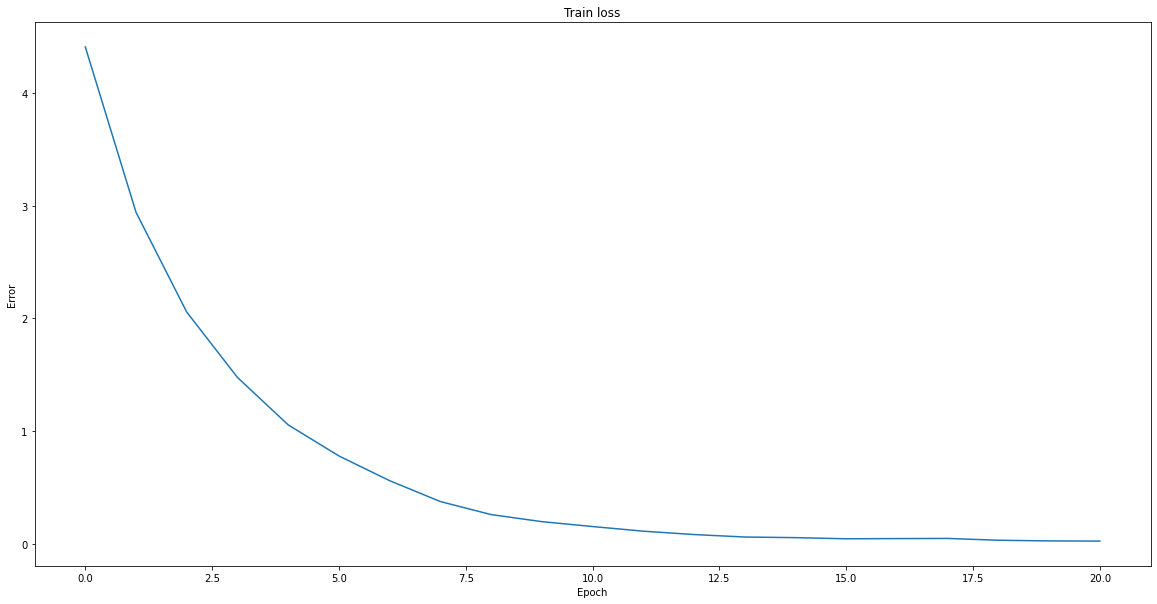

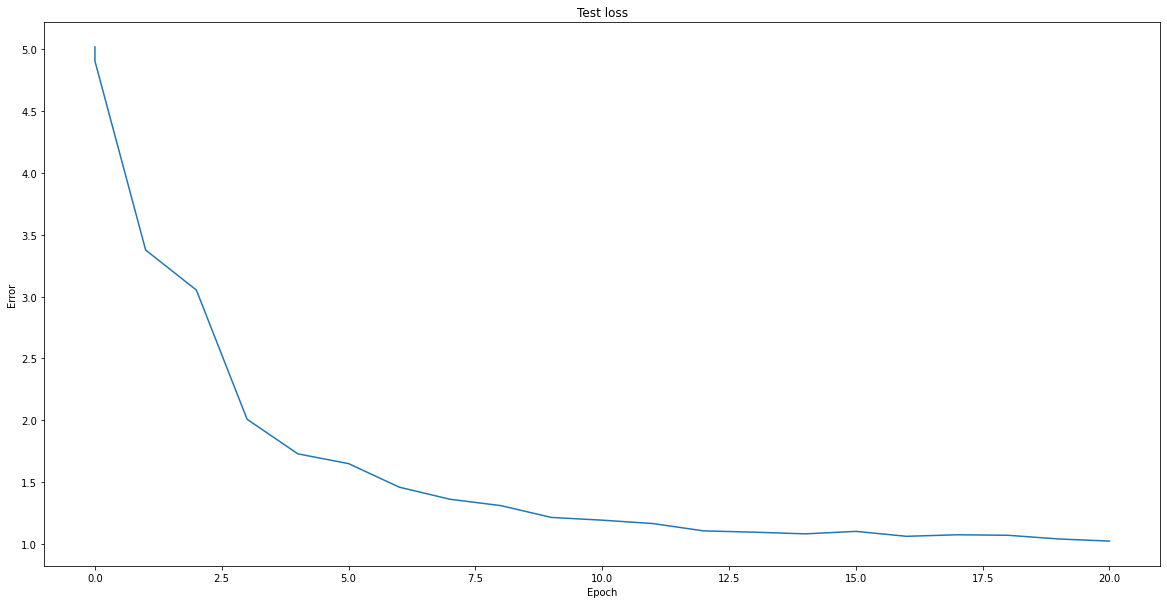

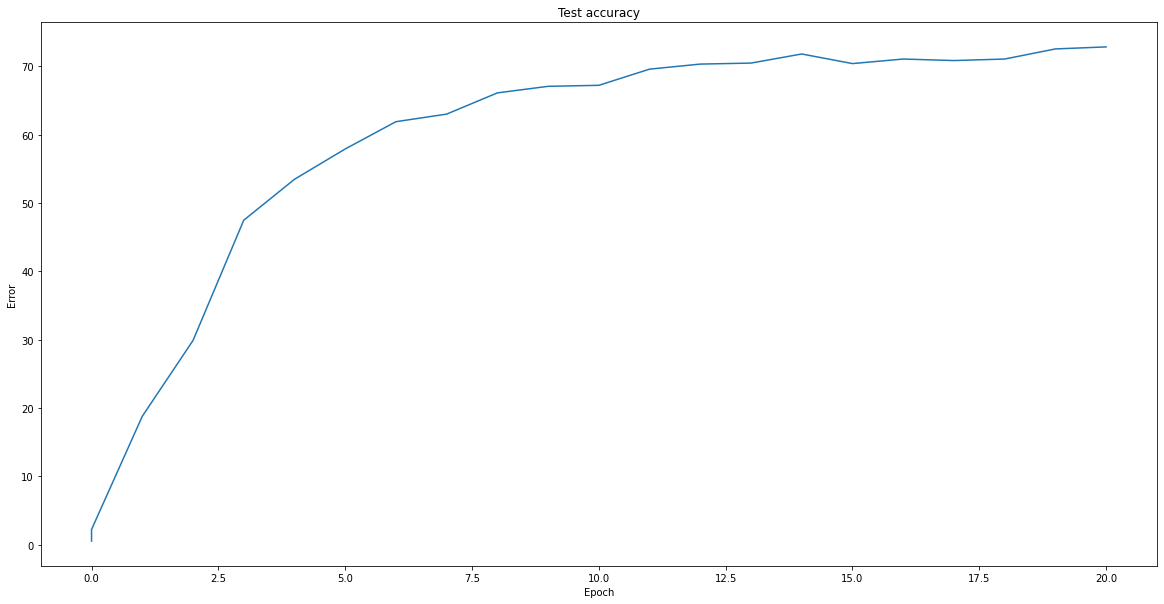

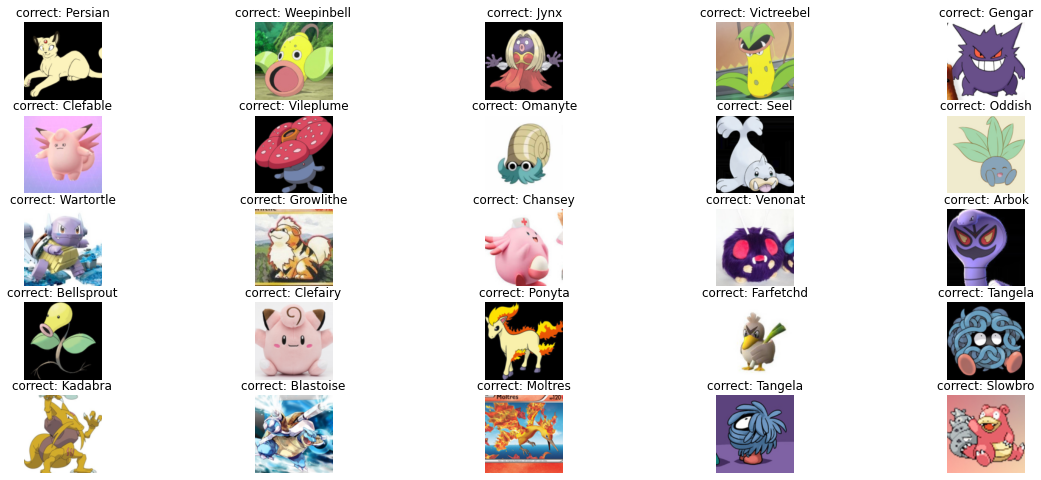

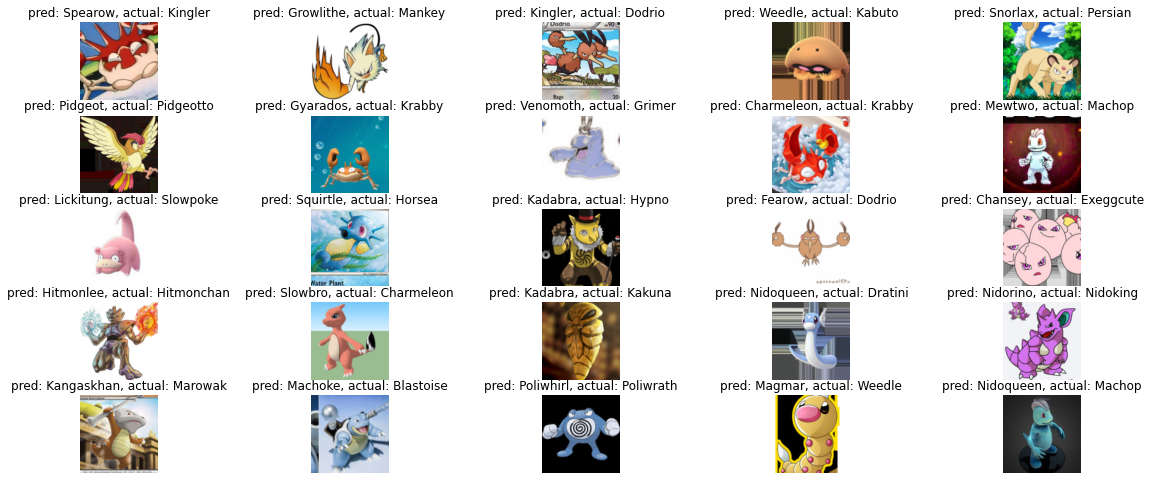

In [ ]:
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

#class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
#name_to_class = {line[1]: line[0] for line in class_names}
#class_names = [line[1] for line in class_names]

pokemap = pd.read_csv(BASE_PATH + 'map.csv')
class_names = pokemap.to_dict()['Name']
name_to_class = {v: k for k, v in class_names.items()}

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model = BaselineNet().to(device)
#####################################
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#####################################
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


# Baseline Model using additional Transforms
### HorizontalFlip
### ColorJitter

Using device cpu
num cpus: 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 5.0171, Accuracy: 15/1352 (1%)



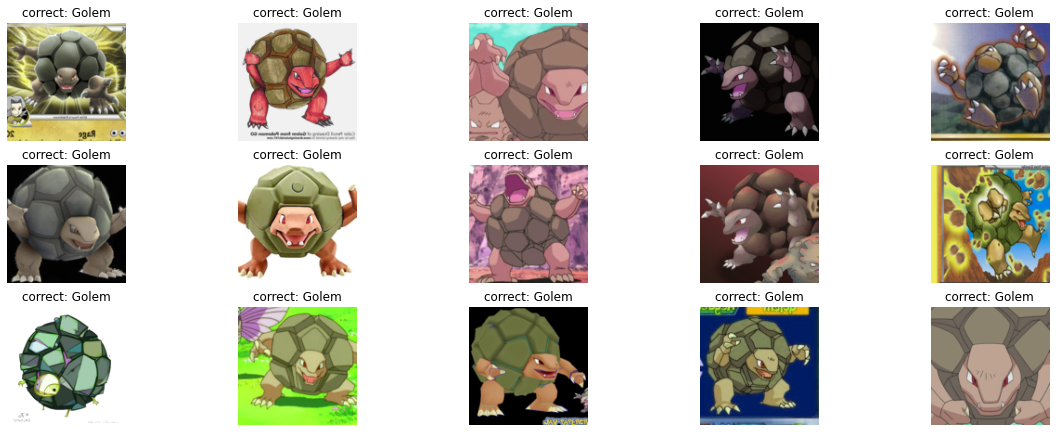

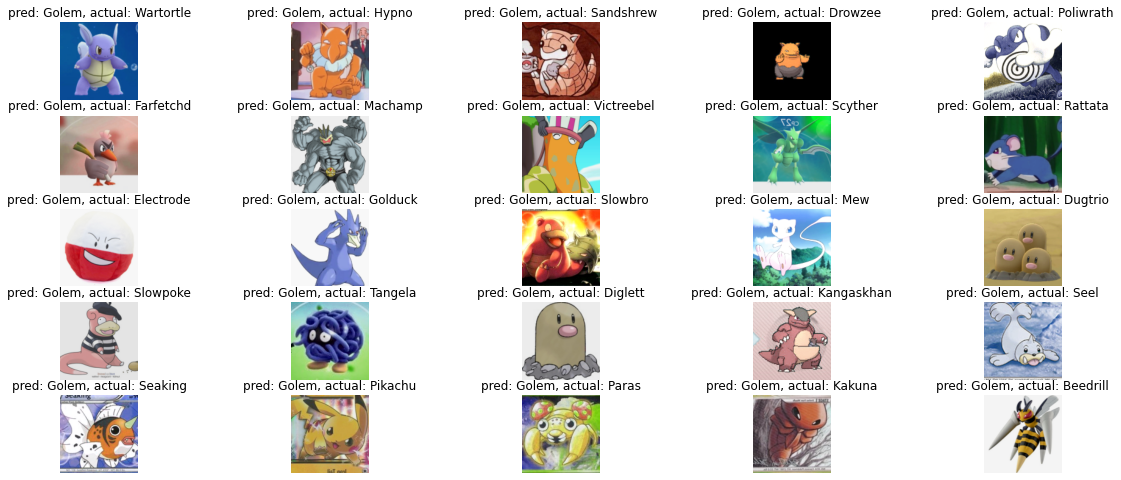

Tue Dec 14 04:10:00 2021 Train Epoch: 0 [0/5404 (0%)]	Loss: 5.219572

Test set: Average loss: 4.9470, Accuracy: 10/1352 (1%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.2/000.pt

Tue Dec 14 04:13:09 2021 Train Epoch: 1 [0/5404 (0%)]	Loss: 3.980544

Test set: Average loss: 3.7883, Accuracy: 160/1352 (12%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.2/001.pt

Tue Dec 14 04:16:16 2021 Train Epoch: 2 [0/5404 (0%)]	Loss: 3.026387

Test set: Average loss: 2.9848, Accuracy: 384/1352 (28%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.2/002.pt

Tue Dec 14 04:19:20 2021 Train Epoch: 3 [0/5404 (0%)]	Loss: 2.603687

Test set: Average loss: 2.9153, Accuracy: 392/1352 (29%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.2/003.pt

Tue Dec 14 04:22:39 2021 Train Epoch: 4 [0/5404 (0%)]	Loss: 1.917450

Test set: Average loss: 2.5152, Accuracy: 488/1352 (36%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.2/004.pt

Tue Dec 14 04:25:49 2021 Train Epoch: 5 [0/5404 (0%)

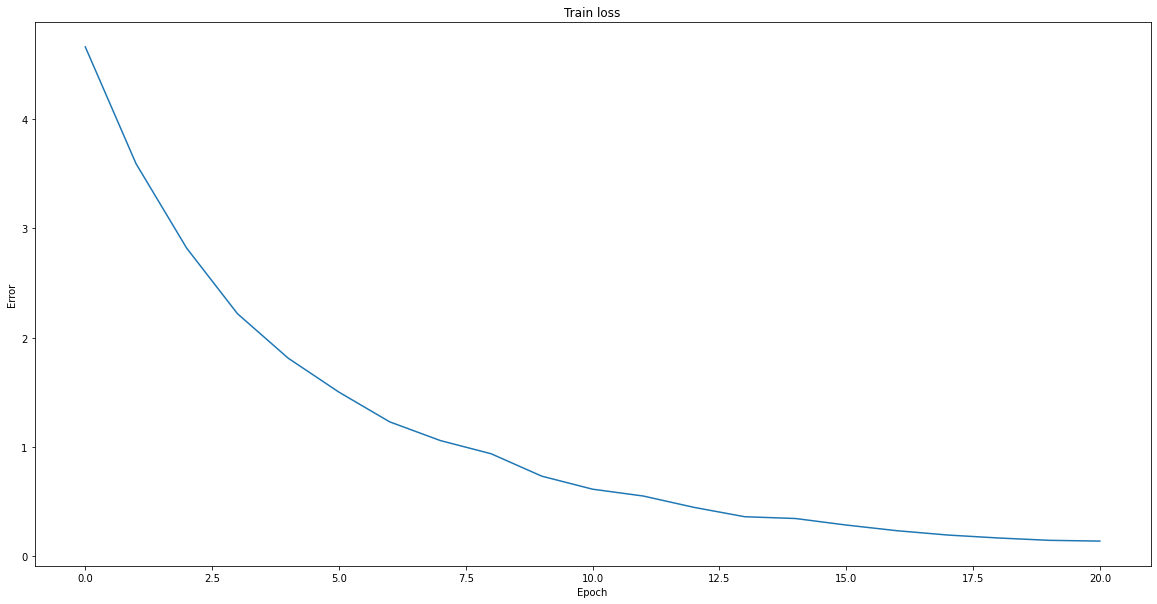

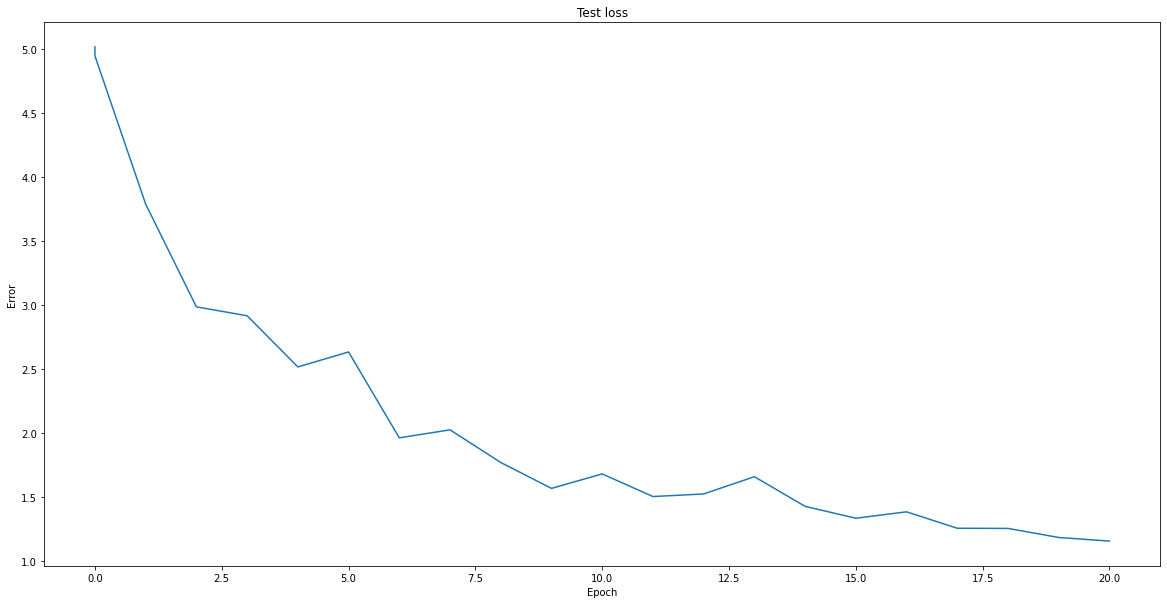

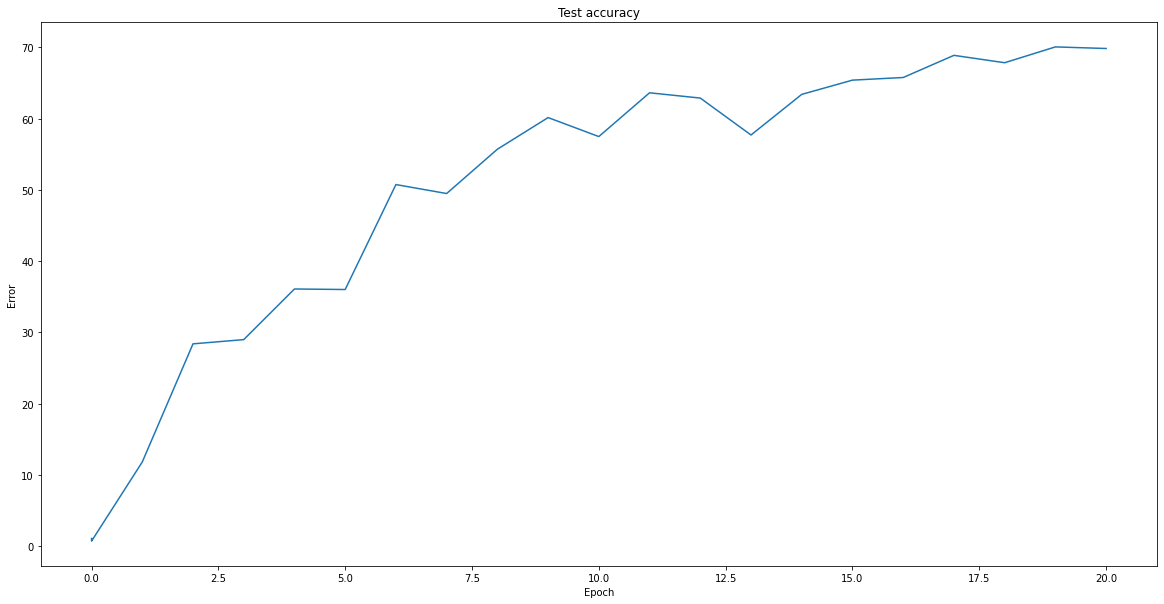

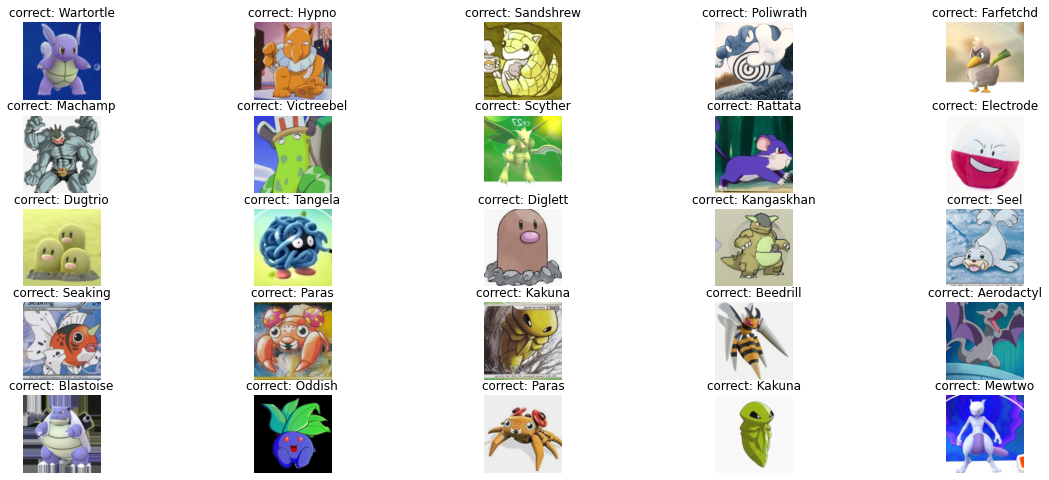

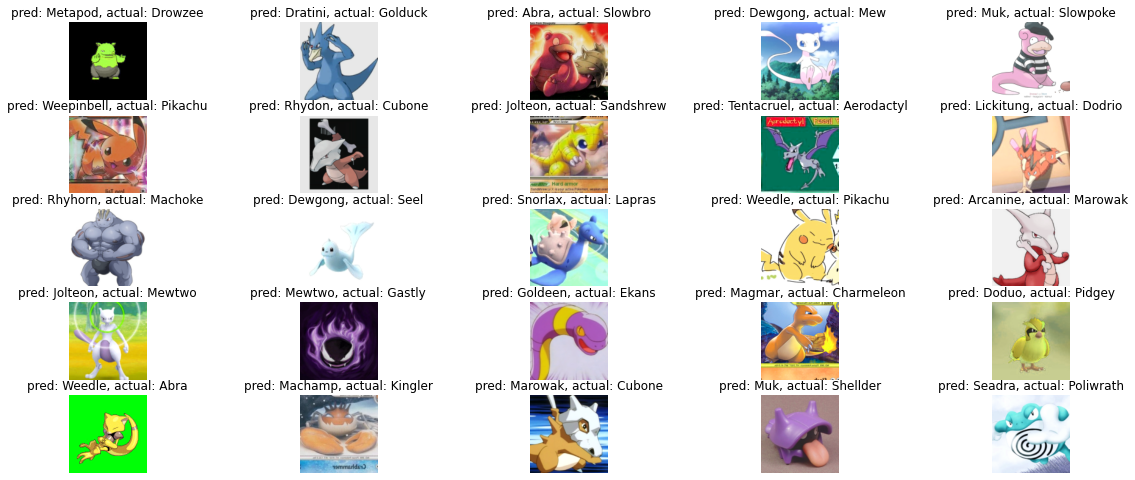

In [ ]:
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

#class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
#name_to_class = {line[1]: line[0] for line in class_names}
#class_names = [line[1] for line in class_names]

pokemap = pd.read_csv(BASE_PATH + 'map.csv')
class_names = pokemap.to_dict()['Name']
name_to_class = {v: k for k, v in class_names.items()}

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model = BaselineNet().to(device)
#####################################
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#####################################
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

# With Scheduled LR Decay

Using device cpu
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
bn1.weight -> 	torch.Size([16]) = 0MB
bn1.bias -> 	torch.Size([16]) = 0MB
bn1.running_mean -> 	torch.Size([16]) = 0MB
bn1.running_var -> 	torch.Size([16]) = 0MB
bn1.num_batches_tracked -> 	torch.Size([]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
bn2.weight -> 	torch.Size([32]) = 0MB
bn2.bias -> 	torch.Size([32]) = 0MB
bn2.running_mean -> 	torch.Size([32]) = 0MB
bn2.running_var -> 	torch.Size([32]) = 0MB
bn2.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
bn3.weight -> 	torch.Size([64]) = 0MB
bn3.bias -> 	torch.Size([64]) = 0MB
bn3.running_mean -> 	torch.Size([64]) = 0MB
bn3.running_var -> 	torch.Size([64]) = 0MB
bn3.num_batches_tracked -> 	torch.Size([]) = 0MB
conv4.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
bn4.weight -> 	torch.Size([128]) = 0MB
bn4.bias -> 	torch.Size([128]) = 0MB
bn4.running_mean -> 	torch.Size([128]) = 0MB
bn4.runni

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 4.7609, Accuracy: 44/1352 (3%)



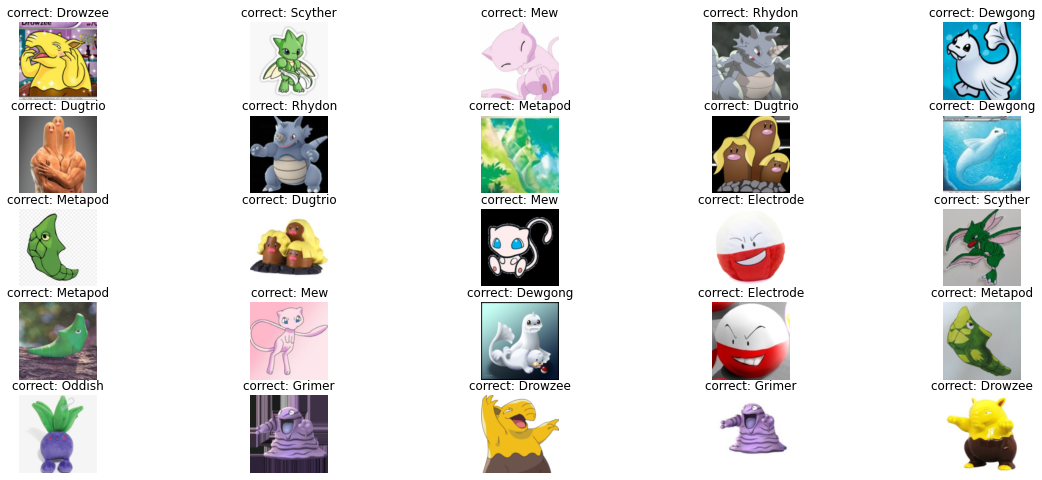

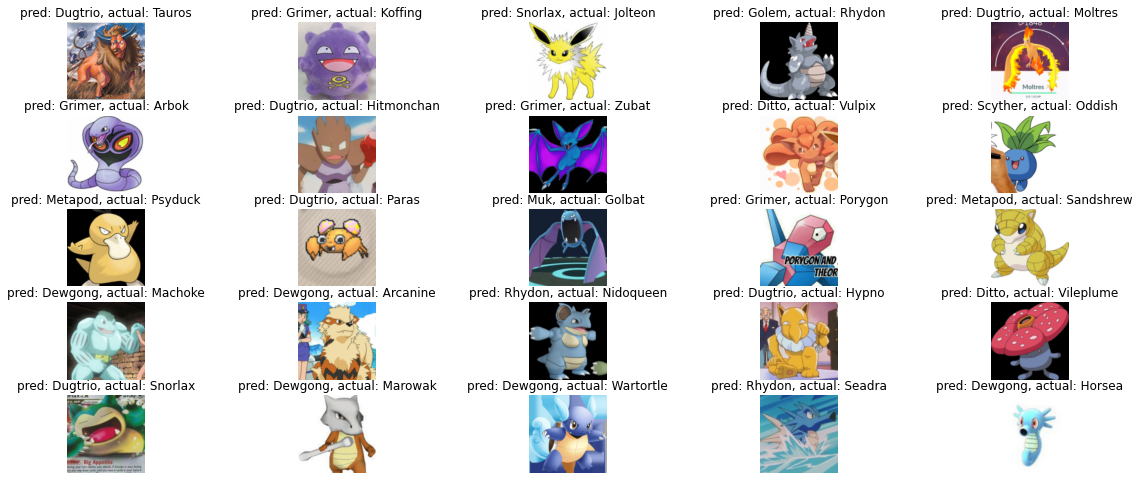

Tue Dec 14 08:31:27 2021 Train Epoch: 1 [0/5404 (0%)]	Loss: 3.433789

Test set: Average loss: 3.1687, Accuracy: 312/1352 (23%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.7/001.pt

Tue Dec 14 08:34:24 2021 Train Epoch: 2 [0/5404 (0%)]	Loss: 2.478393

Test set: Average loss: 2.8297, Accuracy: 382/1352 (28%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.7/002.pt

Tue Dec 14 08:37:12 2021 Train Epoch: 3 [0/5404 (0%)]	Loss: 1.657873

Test set: Average loss: 2.2373, Accuracy: 567/1352 (42%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.7/003.pt

Tue Dec 14 08:39:57 2021 Train Epoch: 4 [0/5404 (0%)]	Loss: 1.251703

Test set: Average loss: 2.0576, Accuracy: 645/1352 (48%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.7/004.pt

Tue Dec 14 08:42:42 2021 Train Epoch: 5 [0/5404 (0%)]	Loss: 0.727787

Test set: Average loss: 1.8146, Accuracy: 724/1352 (54%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.7/005.pt

Tue Dec 14 08:45:46 2021 Train Epoch: 6 [0/5404 (0

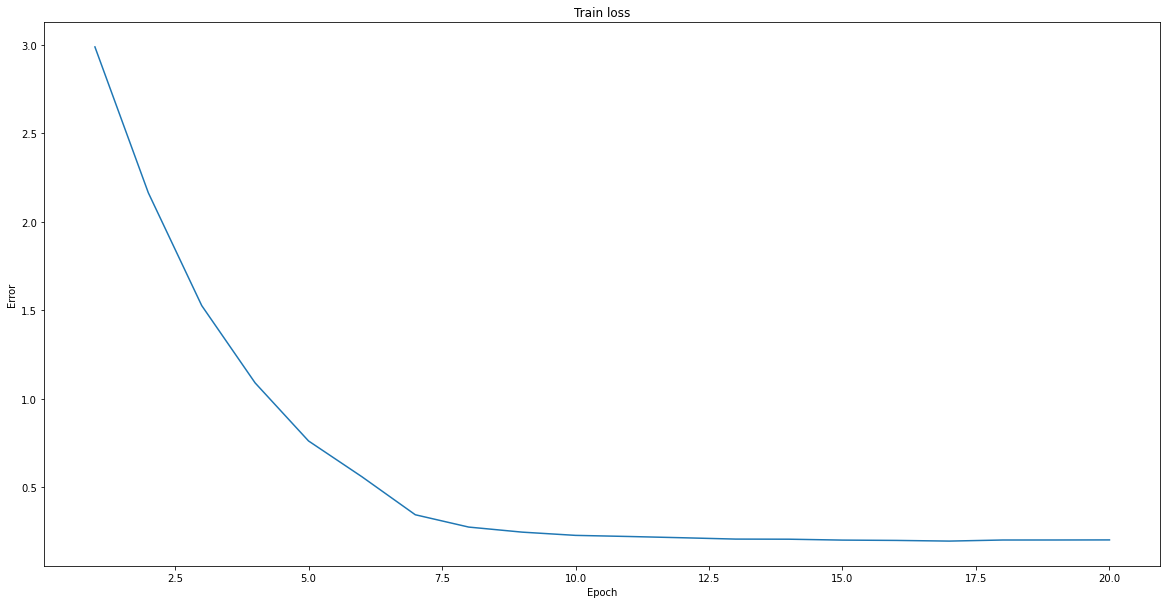

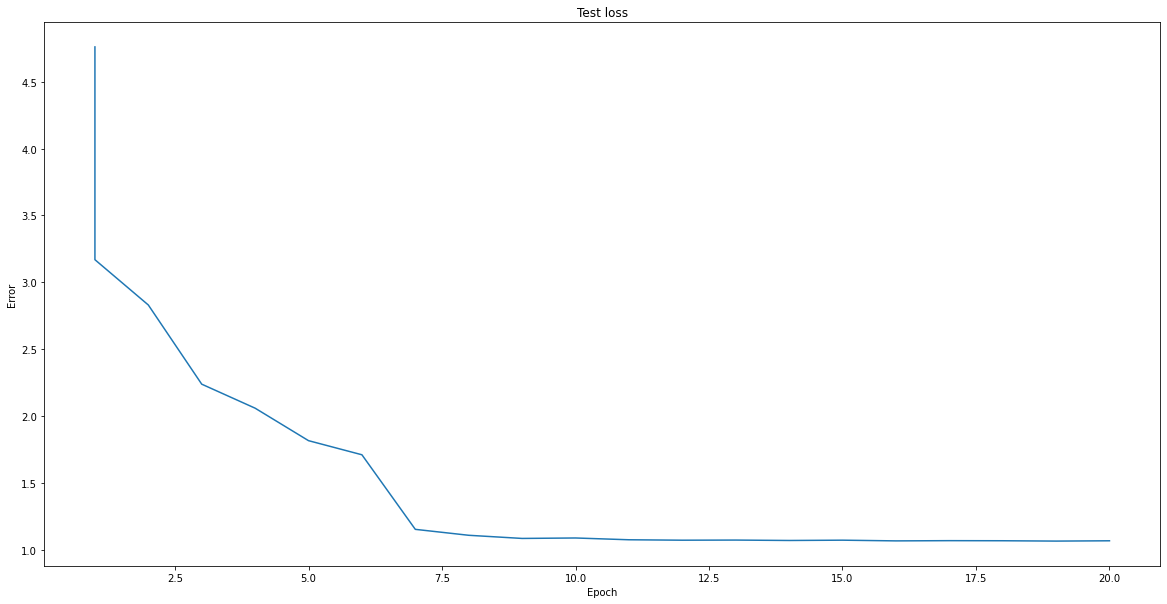

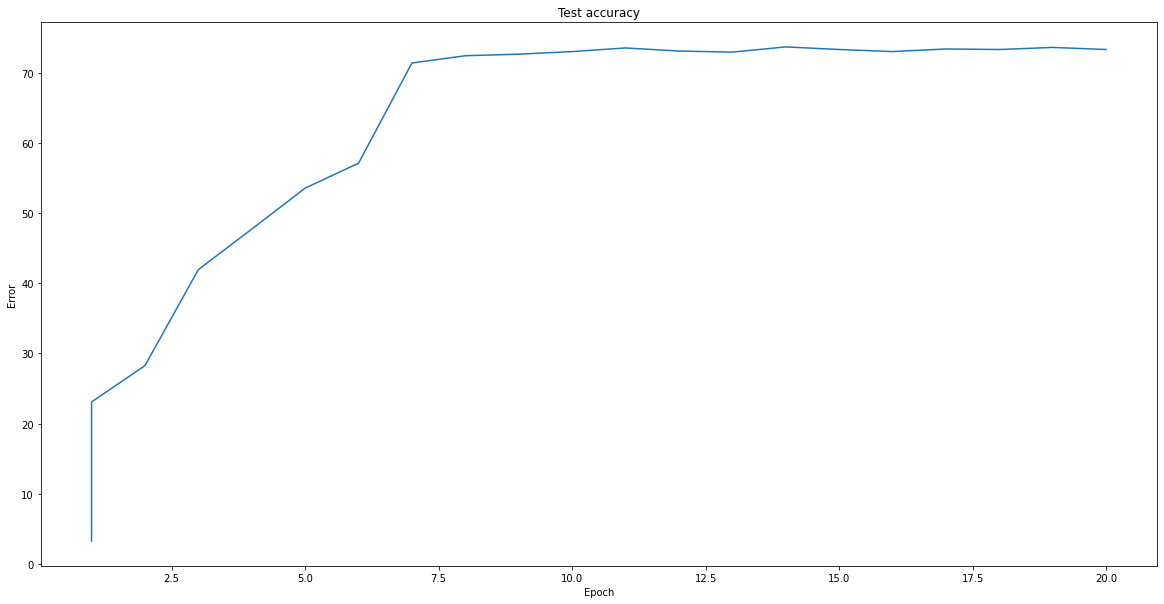

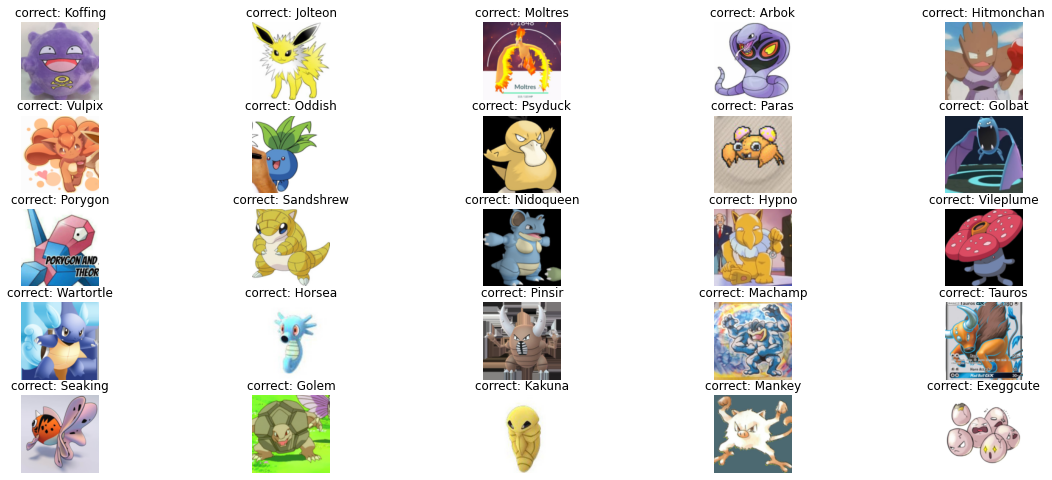

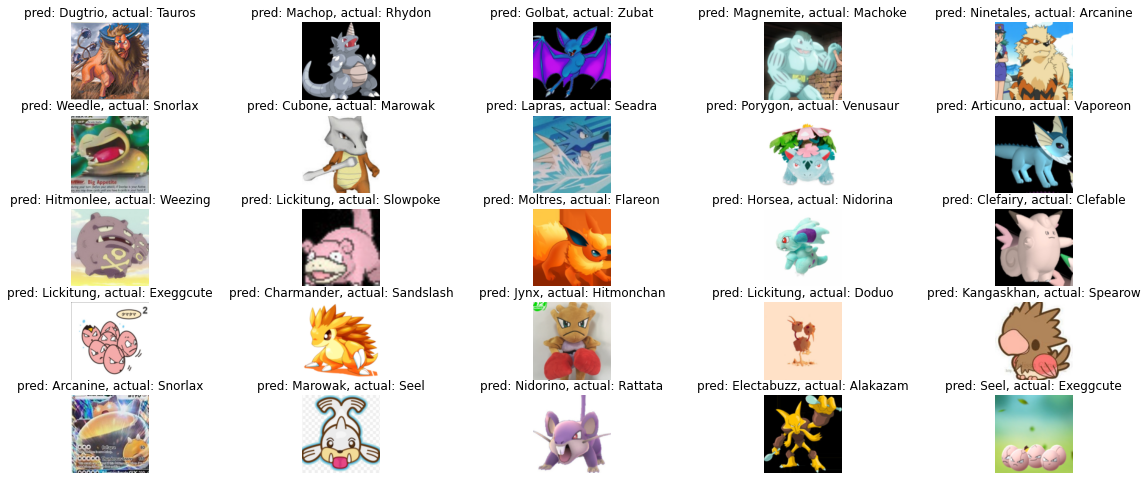

In [ ]:
use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

#class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
#name_to_class = {line[1]: line[0] for line in class_names}#class_names = [line[1] for line in class_names]

pokemap = pd.read_csv(BASE_PATH + 'map.csv')
class_names = pokemap.to_dict()['Name']
name_to_class = {v: k for k, v in class_names.items()}

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model = BaselineNet().to(device)
#####################################
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
#####################################
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        scheduler.step()
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

# Resnet18 for Feature Extraction

In [ ]:
edits = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

poke_data = PokemonDataset(BASE_PATH + 'data.csv', transform=edits)
split = [5404, 1352] # about 80-20
train_set, test_set = torch.utils.data.random_split(poke_data, split)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 151)

In [ ]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0005, verbose=1):
    net.to(device)
    losses = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize 
            outputs = net(inputs)
            loss = net.loss(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            # print statistics
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
    return losses

def accuracy(net, dataloader):
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net.test(images)
            if outputs.size(1) == 1:
                predicted = outputs.apply_(lambda x: 1 if x > 0.5 else 0)
            else:
                _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
model.loss = nn.CrossEntropyLoss()
model.test = model.forward

resnet_losses =  train(model, train_loader, epochs=4, lr=.01)
resnet_losses += train(model, train_loader, epochs=1, lr=.001)
 
plt.plot(smooth(resnet_losses, 50), color='black')

In [ ]:
print("Training accuracy: %f" % accuracy(model, train_loader))
print("Testing  accuracy: %f" % accuracy(model, test_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training accuracy: 0.496854
Testing  accuracy: 0.400888


# Trimmed BaselineNet
## Additional Transforms
## Smaller Network
## Lower Momentum
## Scheduler

In [39]:
class TrimmedBaselineNet(nn.Module):
    def __init__(self):
        super(TrimmedBaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 4 * 4, 151)

        self.accuracy = None

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 64x64x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 32x32x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 16x16x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 8x8x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 4x4x256

        x = torch.flatten(x, 1)                                                    # vector 2048
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [42]:
edits = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ColorJitter(.1,.1,.1,.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 30)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2)),
    transforms.ToTensor()
])

poke_data = PokemonDataset(BASE_PATH + 'data.csv', transform=edits)
split = [5454, 1302] # about 82-18
train_set, test_set = torch.utils.data.random_split(poke_data, split)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
bn1.weight -> 	torch.Size([16]) = 0MB
bn1.bias -> 	torch.Size([16]) = 0MB
bn1.running_mean -> 	torch.Size([16]) = 0MB
bn1.running_var -> 	torch.Size([16]) = 0MB
bn1.num_batches_tracked -> 	torch.Size([]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
bn2.weight -> 	torch.Size([32]) = 0MB
bn2.bias -> 	torch.Size([32]) = 0MB
bn2.running_mean -> 	torch.Size([32]) = 0MB
bn2.running_var -> 	torch.Size([32]) = 0MB
bn2.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
bn3.weight -> 	torch.Size([64]) = 0MB
bn3.bias -> 	torch.Size([64]) = 0MB
bn3.running_mean -> 	torch.Size([64]) = 0MB
bn3.running_var -> 	torch.Size([64]) = 0MB
bn3.num_batches_tracked -> 	torch.Size([]) = 0MB
conv4.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
bn4.weight -> 	torch.Size([128]) = 0MB
bn4.bias -> 	torch.Size([128]) = 0MB
bn4.running_mean -> 	torch.Size([128]) = 0MB
bn4.runn

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 4.8321, Accuracy: 30/1302 (2%)



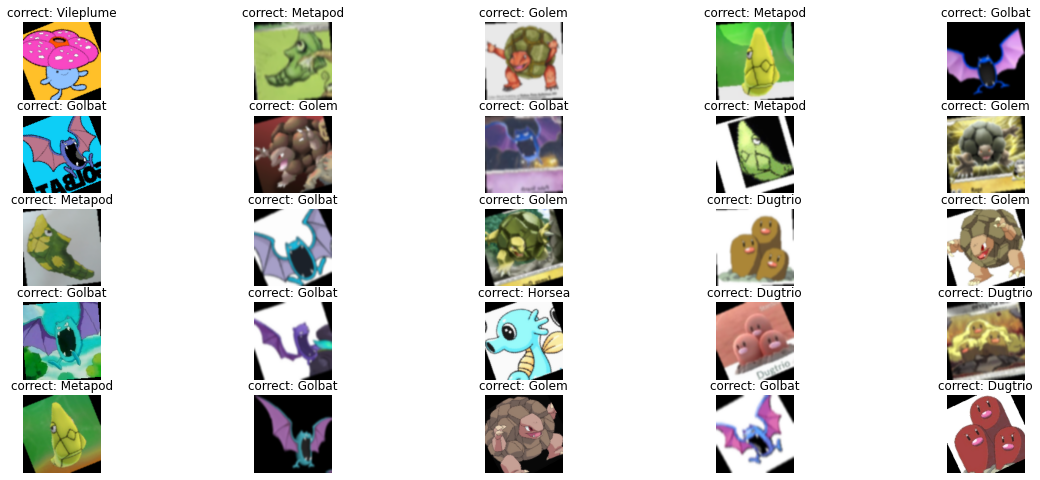

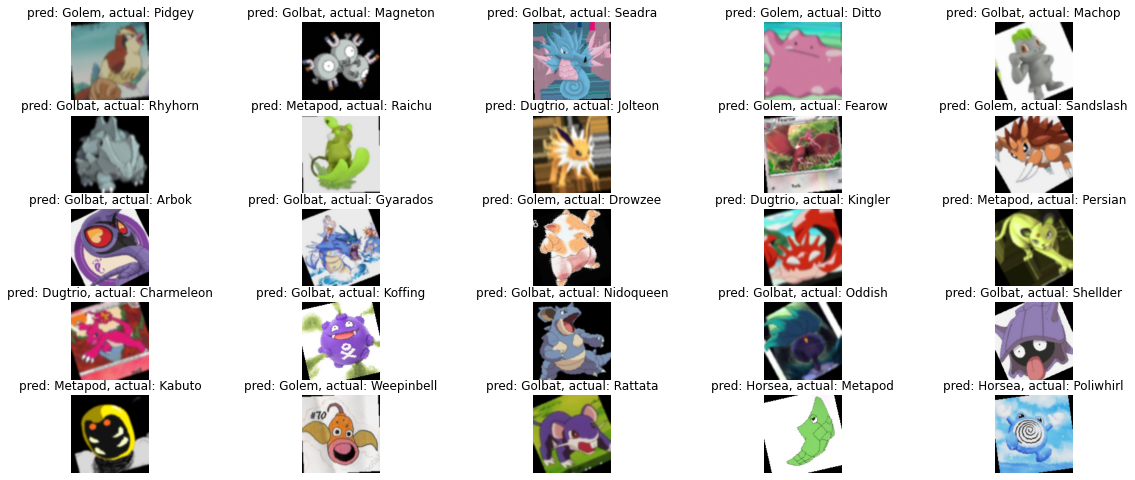

Tue Dec 14 22:49:04 2021 Train Epoch: 0 [0/5454 (0%)]	Loss: 3.877923

Test set: Average loss: 3.7340, Accuracy: 187/1302 (14%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.9/000.pt

Tue Dec 14 22:50:16 2021 Train Epoch: 1 [0/5454 (0%)]	Loss: 3.283942

Test set: Average loss: 3.0432, Accuracy: 334/1302 (26%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.9/001.pt

Tue Dec 14 22:51:28 2021 Train Epoch: 2 [0/5454 (0%)]	Loss: 2.589643

Test set: Average loss: 2.6524, Accuracy: 443/1302 (34%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.9/002.pt

Tue Dec 14 22:52:40 2021 Train Epoch: 3 [0/5454 (0%)]	Loss: 2.114749

Test set: Average loss: 2.4597, Accuracy: 495/1302 (38%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.9/003.pt

Tue Dec 14 22:53:51 2021 Train Epoch: 4 [0/5454 (0%)]	Loss: 1.911113

Test set: Average loss: 2.4042, Accuracy: 540/1302 (41%)

Saved /gdrive/My Drive/colab_files/490_final/logs/0.9/004.pt

Tue Dec 14 22:55:02 2021 Train Epoch: 5 [0/5454 (0

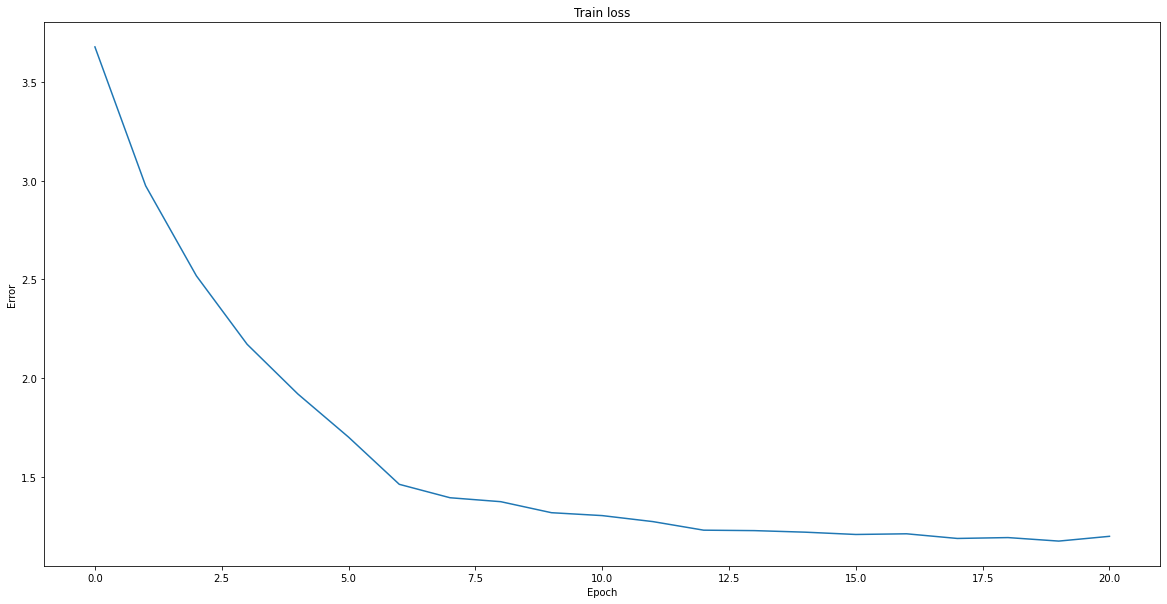

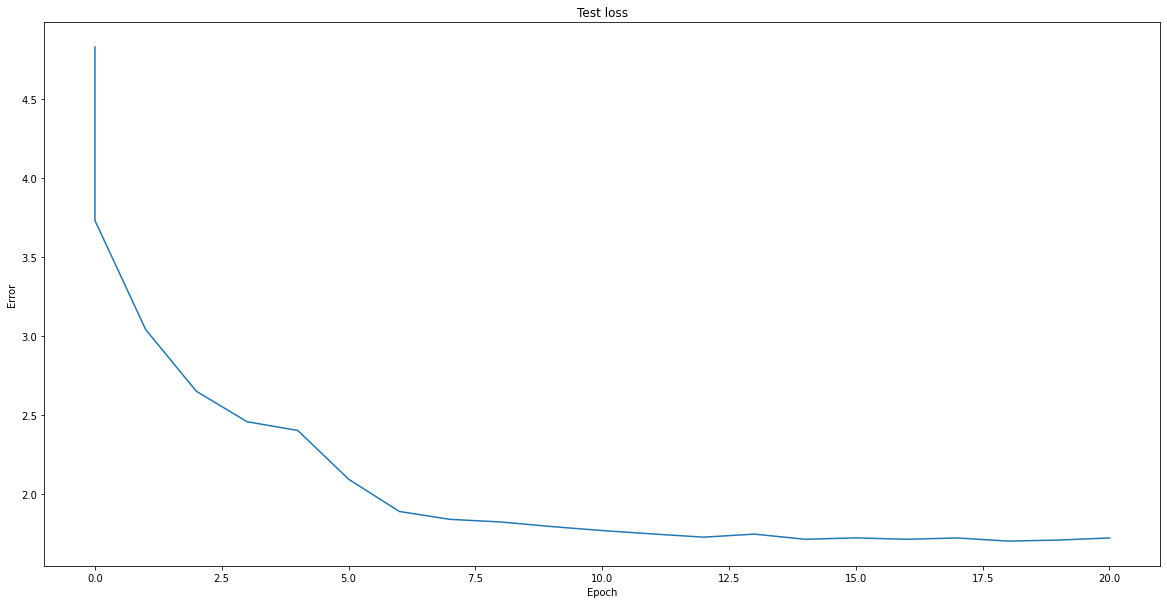

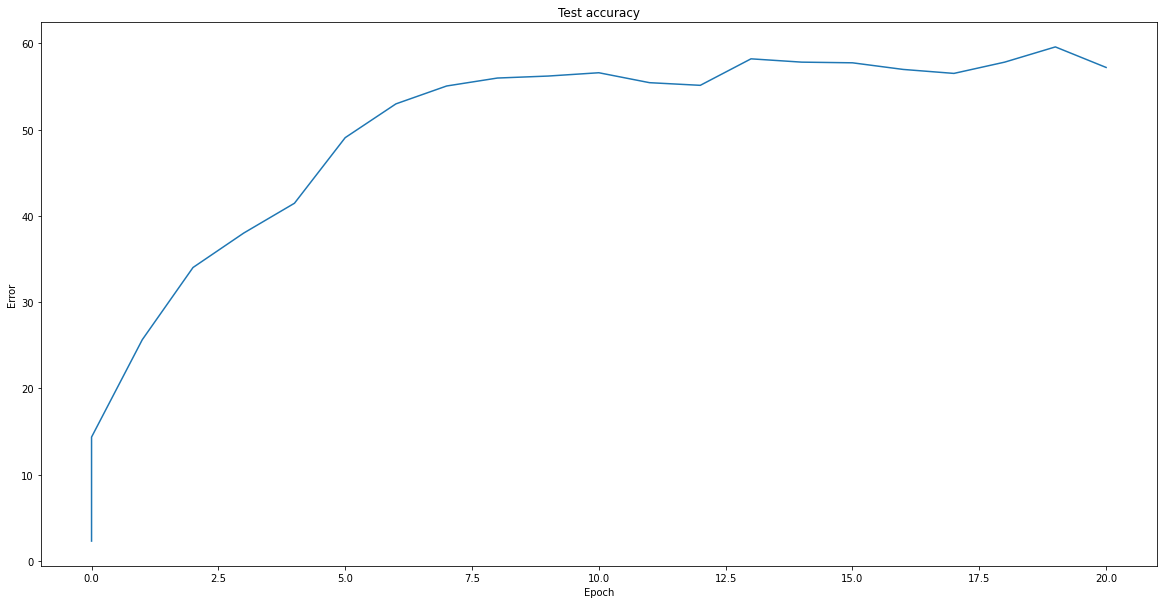

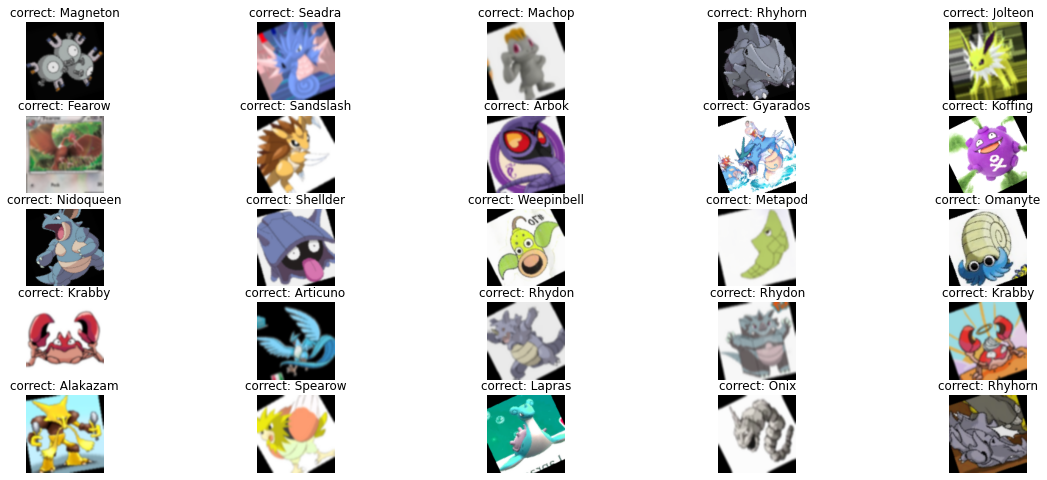

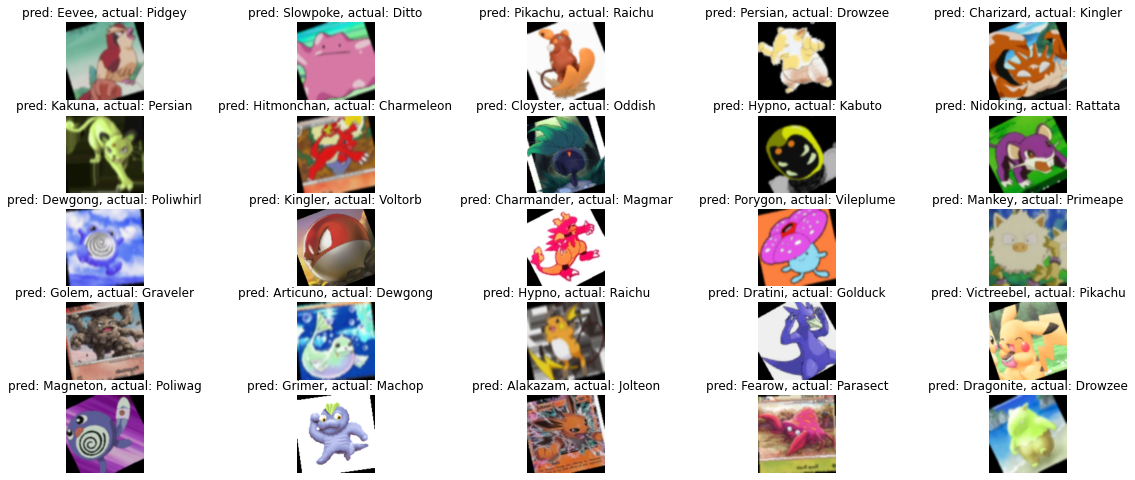

In [43]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.8
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.9"
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

#class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
#name_to_class = {line[1]: line[0] for line in class_names}#class_names = [line[1] for line in class_names]

pokemap = pd.read_csv(BASE_PATH + 'map.csv')
class_names = pokemap.to_dict()['Name']
name_to_class = {v: k for k, v in class_names.items()}

model = TrimmedBaselineNet().to(device)
#####################################
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)
#####################################
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        scheduler.step()
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print(train_losses)
    print(test_losses)
    print(test_accuracies)
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

# LargerNet + Augmentations

In [8]:
class ExtBaselineNet(nn.Module):
    def __init__(self):
        super(ExtBaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv6 = nn.Conv2d(256, 512, 3, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 2 * 2, 151)

        self.accuracy = None

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2) # 64x64x16
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2) # 32x32x32
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2) # 16x16x64
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2) # 8x8x128
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2) # 4x4x256
        x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), kernel_size=2, stride=2) # 2x2x512

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [26]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.00080
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "2.0"
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

edits = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ColorJitter(.1,.03,.1,.03),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-24, 24)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1)),
    transforms.ToTensor()
])

poke_data = PokemonDataset(BASE_PATH + 'data.csv', transform=edits)
split = [5454, 1302] # about 82-18
train_set, test_set = torch.utils.data.random_split(poke_data, split)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
bn1.weight -> 	torch.Size([16]) = 0MB
bn1.bias -> 	torch.Size([16]) = 0MB
bn1.running_mean -> 	torch.Size([16]) = 0MB
bn1.running_var -> 	torch.Size([16]) = 0MB
bn1.num_batches_tracked -> 	torch.Size([]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
bn2.weight -> 	torch.Size([32]) = 0MB
bn2.bias -> 	torch.Size([32]) = 0MB
bn2.running_mean -> 	torch.Size([32]) = 0MB
bn2.running_var -> 	torch.Size([32]) = 0MB
bn2.num_batches_tracked -> 	torch.Size([]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
bn3.weight -> 	torch.Size([64]) = 0MB
bn3.bias -> 	torch.Size([64]) = 0MB
bn3.running_mean -> 	torch.Size([64]) = 0MB
bn3.running_var -> 	torch.Size([64]) = 0MB
bn3.num_batches_tracked -> 	torch.Size([]) = 0MB
conv4.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
bn4.weight -> 	torch.Size([128]) = 0MB
bn4.bias -> 	torch.Size([128]) = 0MB
bn4.running_mean -> 	torch.Size([128]) = 0MB
bn4.runn

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test set: Average loss: 0.8251, Accuracy: 1014/1302 (78%)



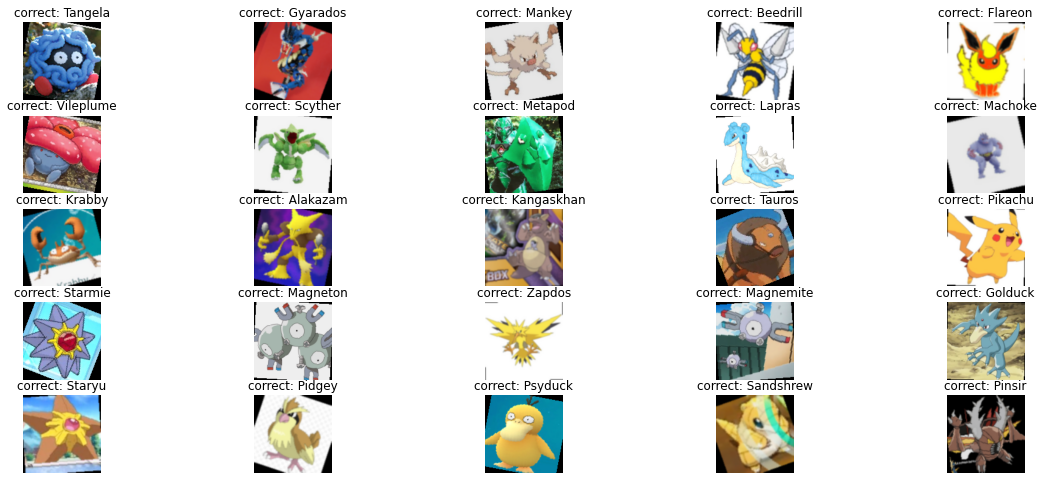

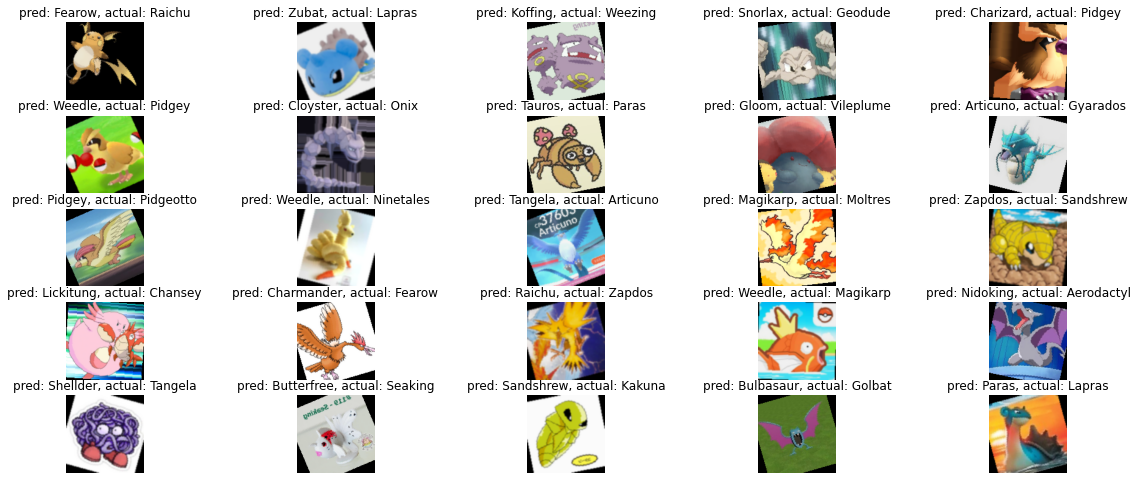

Wed Dec 15 00:56:24 2021 Train Epoch: 25 [0/5454 (0%)]	Loss: 0.734400

Test set: Average loss: 0.8098, Accuracy: 1034/1302 (79%)

Saved /gdrive/My Drive/colab_files/490_final/logs/2.0/025.pt

Wed Dec 15 00:57:41 2021 Train Epoch: 26 [0/5454 (0%)]	Loss: 0.797963

Test set: Average loss: 0.8402, Accuracy: 1018/1302 (78%)

Wed Dec 15 00:58:54 2021 Train Epoch: 27 [0/5454 (0%)]	Loss: 0.668119

Test set: Average loss: 0.8314, Accuracy: 1011/1302 (78%)

Wed Dec 15 01:00:06 2021 Train Epoch: 28 [0/5454 (0%)]	Loss: 0.729053

Test set: Average loss: 0.8314, Accuracy: 1006/1302 (77%)

Wed Dec 15 01:01:18 2021 Train Epoch: 29 [0/5454 (0%)]	Loss: 0.801966

Test set: Average loss: 0.8319, Accuracy: 1014/1302 (78%)

Wed Dec 15 01:02:37 2021 Train Epoch: 30 [0/5454 (0%)]	Loss: 0.785713

Test set: Average loss: 0.8049, Accuracy: 1024/1302 (79%)

[(25, 0.8021787079897794), (26, 0.7912286167795007), (27, 0.7771203870123083), (28, 0.7753153524615548), (29, 0.7788459929552946), (30, 0.7603814845735376)]
[

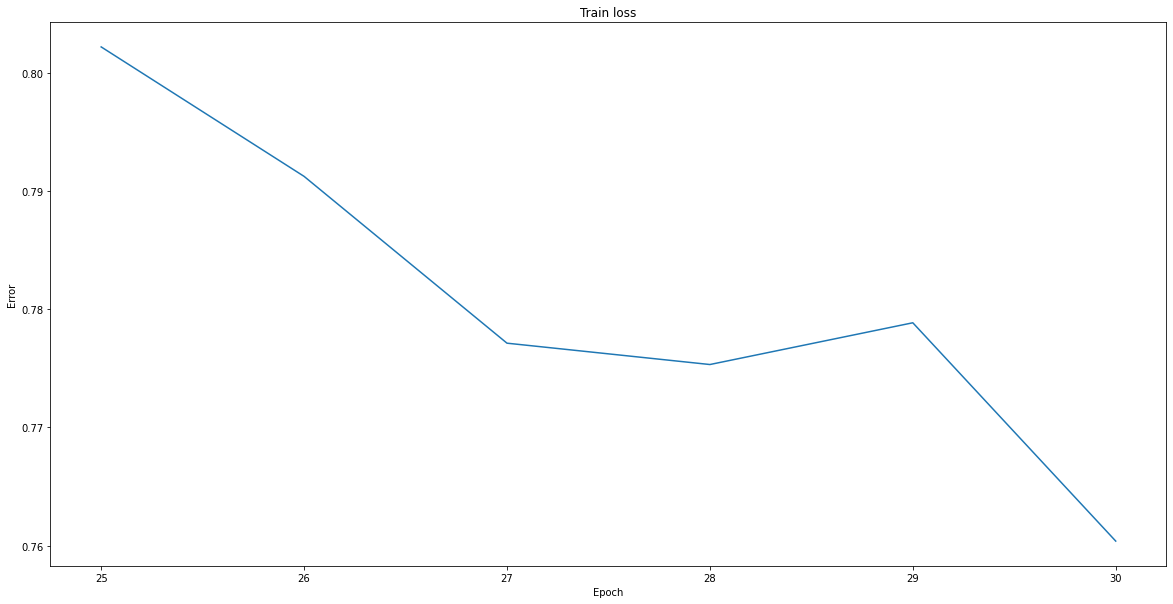

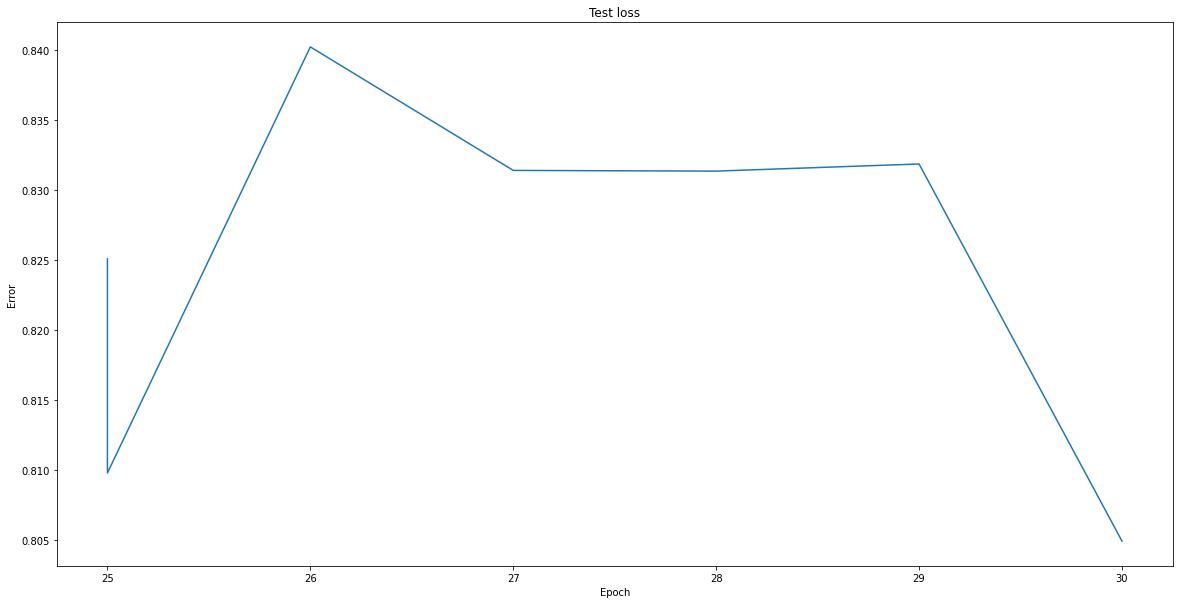

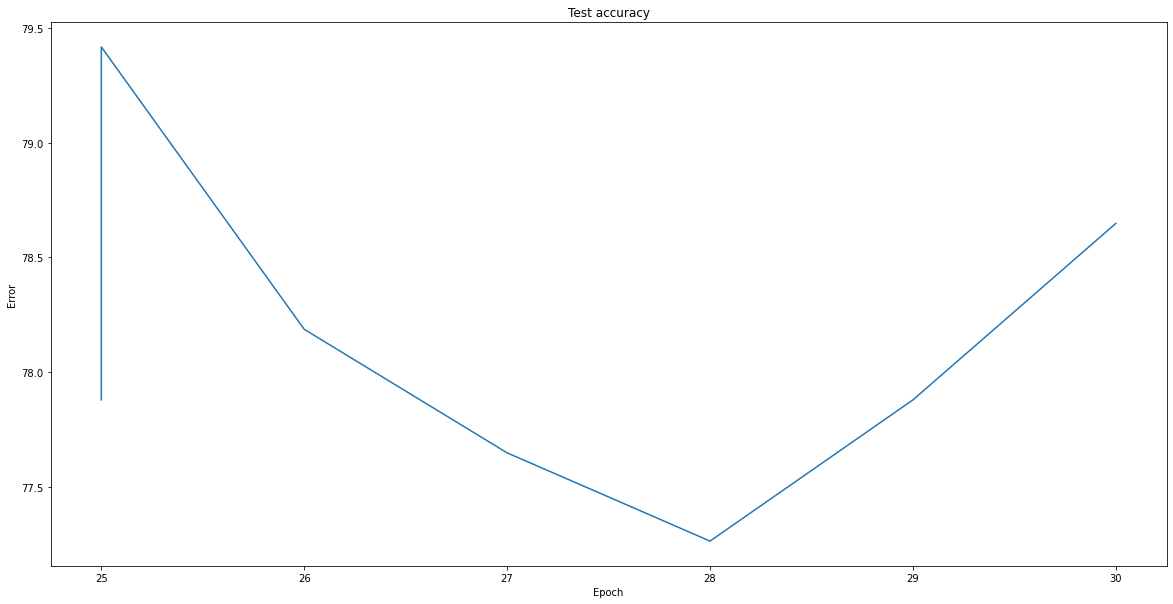

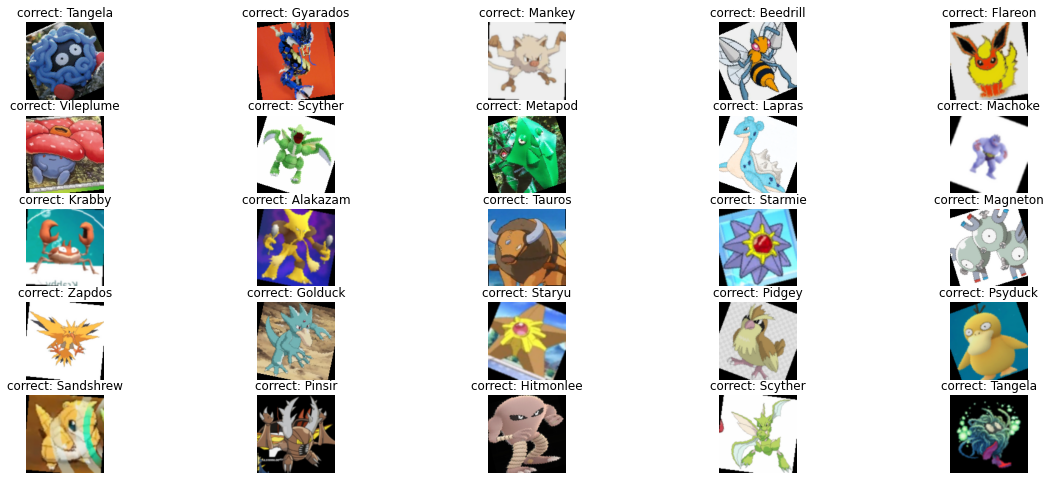

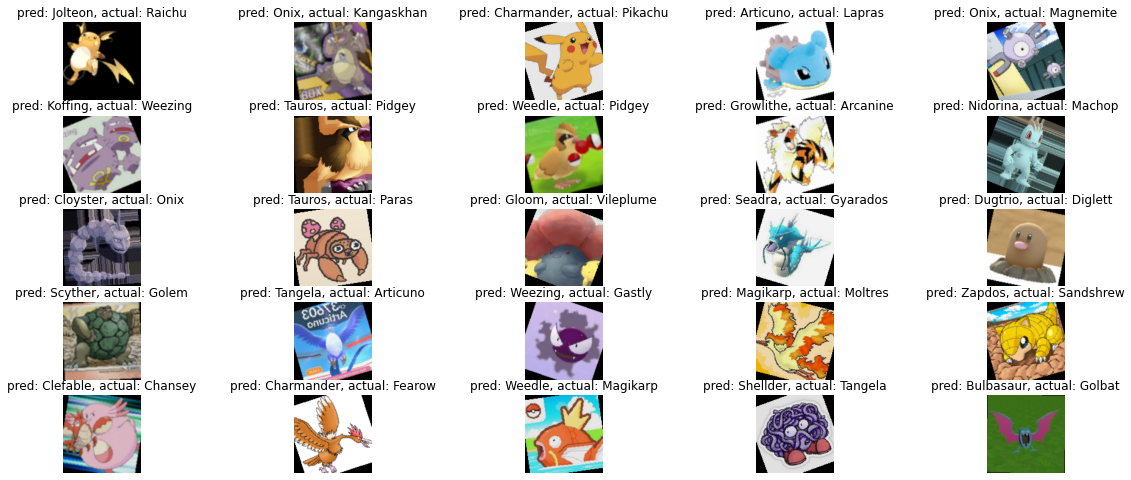

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

#class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
#name_to_class = {line[1]: line[0] for line in class_names}#class_names = [line[1] for line in class_names]

pokemap = pd.read_csv(BASE_PATH + 'map.csv')
class_names = pokemap.to_dict()['Name']
name_to_class = {v: k for k, v in class_names.items()}

model = ExtBaselineNet().to(device)
#####################################
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
#####################################
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        scheduler.step()
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    print(train_losses)
    print(test_losses)
    print(test_accuracies)
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])